# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 27
samples = 10

In [2]:
import time
import random
import math

## PyQrack

In [3]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [4]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 1.0696800109144533e-05, 2: 1.047050004672201e-05, 3: 1.111849992412317e-05, 4: 1.3539000019591185e-05, 5: 1.535019996481424e-05, 6: 1.7460200024288496e-05, 7: 2.0485300001382712e-05, 8: 9.086440004466568e-05, 9: 2.7483300073072314e-05, 10: 2.8811600031986018e-05, 11: 2.9941199954919284e-05, 12: 3.282990005573083e-05, 13: 3.596289998313296e-05, 14: 3.901020008925116e-05, 15: 4.241509996063542e-05, 16: 4.632719992514467e-05, 17: 4.979010004717566e-05, 18: 5.3463199901671035e-05, 19: 5.8456799979467175e-05, 20: 6.199830004334217e-05, 21: 6.572790002792316e-05, 22: 6.961080007386044e-05, 23: 7.393099995169904e-05, 24: 7.745299994894594e-05, 25: 8.175619996109162e-05, 26: 8.618429997113708e-05, 27: 9.014520005621308e-05}


### GHZ state initialization

In [5]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    sim.set_reactive_separate(False)
    sim.h(0)
    for i in range(n - 1):
        sim.mcx([i], i + 1)
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_k_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_k_results[n] = sum(width_results) / samples

print(qrack_k_results)

{1: 1.1626899959082947e-05, 2: 4.7308400007750605e-05, 3: 0.00010939479998341994, 4: 0.00013432120008474157, 5: 0.00010832059997483157, 6: 0.00017502709993095779, 7: 0.00020265839993953704, 8: 0.0002314597998974932, 9: 0.00027425829989624617, 10: 0.00044842499996775584, 11: 0.0015529603000231872, 12: 0.001807095399908576, 13: 0.0019233443999382871, 14: 0.0021702213000025948, 15: 0.0026513654999689605, 16: 0.0030771677000757335, 17: 0.0032941368999672704, 18: 0.00364750659996389, 19: 0.004887824700017518, 20: 0.009531704900018667, 21: 0.015804623600070046, 22: 0.029648254800031283, 23: 0.05640978139995241, 24: 0.1121291915000711, 25: 0.22450272469991434, 26: 0.45944714359993666, 27: 0.9195865323999441}


## FFTW ("Classical" DFT)

In [6]:
import pyfftw
import numpy as np

# See https://blog.hpc.qmul.ac.uk/pyfftw.html
pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

In [7]:
fftw_0_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.zeros_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.ifft(io_array, overwrite_input=True, threads = (16 if (n > 20) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_0_results[n] = sum(width_results) / samples

print(fftw_0_results)

{1: 0.00011056429998461681, 2: 3.461800001787196e-05, 3: 3.6271799854148415e-05, 4: 3.462009999566362e-05, 5: 0.00012188219998279237, 6: 5.189139988033275e-05, 7: 3.912409988515719e-05, 8: 3.850230004900368e-05, 9: 4.0848099979484685e-05, 10: 8.595809999860649e-05, 11: 5.246830000942282e-05, 12: 7.091259990374966e-05, 13: 0.00012537100001281943, 14: 0.0002212228999724175, 15: 0.00044251599993003763, 16: 0.0009259541000119498, 17: 0.0015886880000380188, 18: 0.002490077599986762, 19: 0.008143824099943232, 20: 0.016672168400009468, 21: 0.016258629600042696, 22: 0.05055580610005563, 23: 0.1010052653000912, 24: 0.20626760369996192, 25: 0.38856031280001846, 26: 0.9238165532000494, 27: 1.8720069937999142}


## Qiskit Aer

In [8]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.004884059599953616, 2: 0.003843401299991456, 3: 0.004520825600047828, 4: 0.0051952370000435625, 5: 0.005960265099929529, 6: 0.006679315400015184, 7: 0.00747320429991305, 8: 0.008308174000012514, 9: 0.009196512800053824, 10: 0.010234878899927935, 11: 0.011157546000094953, 12: 0.01272737930007679, 13: 0.014018713700033913, 14: 0.014905901899965102, 15: 0.016042514599985225, 16: 0.0203855676000785, 17: 0.020039145299961092, 18: 0.02603678439995747, 19: 0.02543634450003083, 20: 0.03236669329999131, 21: 0.046049270100093055, 22: 0.06071182820001013, 23: 0.1088715713000056, 24: 0.20285323619996234, 25: 0.38725163539993446, 26: 0.8224787023999852, 27: 1.6811714726000446}


## Qulacs

In [9]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00032754779999777384, 2: 0.00046313830002873144, 3: 0.0005533778999051719, 4: 0.0007303560000309517, 5: 0.0008962302000782074, 6: 0.0011833686000954913, 7: 0.0014182956000695413, 8: 0.0017239592999430896, 9: 0.00202326150006229, 10: 0.0024044458999469497, 11: 0.002892227799975444, 12: 0.0035462376000396033, 13: 0.004125318000023981, 14: 0.004627556000150435, 15: 0.005234172899918121, 16: 0.009097369300161518, 17: 0.0160429505999673, 18: 0.017829949799897805, 19: 0.02748372339992784, 20: 0.045298415900015244, 21: 0.08596511099999589, 22: 0.17088076320001164, 23: 0.3358777711999664, 24: 0.6740512775999378, 25: 1.3453883069000312, 26: 2.7591999108000436, 27: 5.663937995599918}


## QCGPU

In [10]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [11]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0005678301999068935, 2: 0.0014258378000704397, 3: 0.0020910011000523808, 4: 0.0035416421999798333, 5: 0.004746205700030259, 6: 0.006367713299960087, 7: 0.007704377199979717, 8: 0.009922022299952005, 9: 0.011959481300027618, 10: 0.01437122600004841, 11: 0.016198934000021835, 12: 0.018487205399924277, 13: 0.020741581599941127, 14: 0.023118163600020124, 15: 0.02638822040003106, 16: 0.030336053899918624, 17: 0.03439894279990767, 18: 0.03953811909996148, 19: 0.04586896320010965, 20: 0.05423635639999702, 21: 0.0700619870999617, 22: 0.09605366770001637, 23: 0.16749736679998933, 24: 0.347226256400063, 25: 0.6941728855000292, 26: 1.4416663653000796, 27: 3.0025718211000365}


## qsimcirq

In [12]:
# See https://github.com/NVIDIA/cuQuantum/discussions/23
# This is the script we run on the appliance:

#import time
#import random
#import math
#import cirq
#import qsimcirq
#import cupy
#
#
#low = 1
#high = 27
#samples = 10
#
#def cuquantum_qft(q):
#    qreg = list(q)
#    for j in range(len(qreg)):
#        for k in range(j):
#            yield (cirq.CZ ** (2**(j-k)))(qreg[j], qreg[k])
#        yield cirq.H(qreg[j])
#
#    start = 0
#    end = len(qreg) - 1
#    while (start < end):
#        yield cirq.SWAP(qreg[start], qreg[end])
#        start += 1
#        end -= 1
#
#    yield cirq.measure(*qreg)
#
#def bench_cuquantum(n):
#    qubits = cirq.LineQubit.range(n)
#    qft = cirq.Circuit(cuquantum_qft(qubits))
#    simulator = qsimcirq.QSimSimulator(qsimcirq.QSimOptions(gpu_mode=1))
#
#    start = time.perf_counter()
#    simulator.run(qft, repetitions=1)
#    return time.perf_counter() - start
#
#cuquantum_results = {}
#for n in range(low, high + 1):
#    width_results = []
#         
#    # Run the benchmarks
#    for i in range(samples):
#        width_results.append(bench_cuquantum(n))
#
#    cuquantum_results[n] = sum(width_results) / samples
#
#print(cuquantum_results)

cuquantum_results = {1: 0.06097247430002426, 2: 0.00147043730007681, 3: 0.0015933172000586638, 4: 0.00182375869999305, 5: 0.002011404500035496, 6: 0.002348685300012221, 7: 0.002692276200014021, 8: 0.003033890699907715, 9: 0.004139108500021393, 10: 0.003898753399926136, 11: 0.004420664200006285, 12: 0.005013838000013493, 13: 0.005542140700072196, 14: 0.006187859600049706, 15: 0.006857221900054356, 16: 0.007660126700056935, 17: 0.009069550999902276, 18: 0.009929025400015234, 19: 0.010890219899874865, 20: 0.014284344799989412, 21: 0.0199182583000038, 22: 0.029318863600065016, 23: 0.051883794399964246, 24: 0.09487093279999499, 25: 0.19184154329991543, 26: 0.3733097560999795, 27: 0.8085636959000112}
print(cuquantum_results)

{1: 0.06097247430002426, 2: 0.00147043730007681, 3: 0.0015933172000586638, 4: 0.00182375869999305, 5: 0.002011404500035496, 6: 0.002348685300012221, 7: 0.002692276200014021, 8: 0.003033890699907715, 9: 0.004139108500021393, 10: 0.003898753399926136, 11: 0.004420664200006285, 12: 0.005013838000013493, 13: 0.005542140700072196, 14: 0.006187859600049706, 15: 0.006857221900054356, 16: 0.007660126700056935, 17: 0.009069550999902276, 18: 0.009929025400015234, 19: 0.010890219899874865, 20: 0.014284344799989412, 21: 0.0199182583000038, 22: 0.029318863600065016, 23: 0.051883794399964246, 24: 0.09487093279999499, 25: 0.19184154329991543, 26: 0.3733097560999795, 27: 0.8085636959000112}


## Results

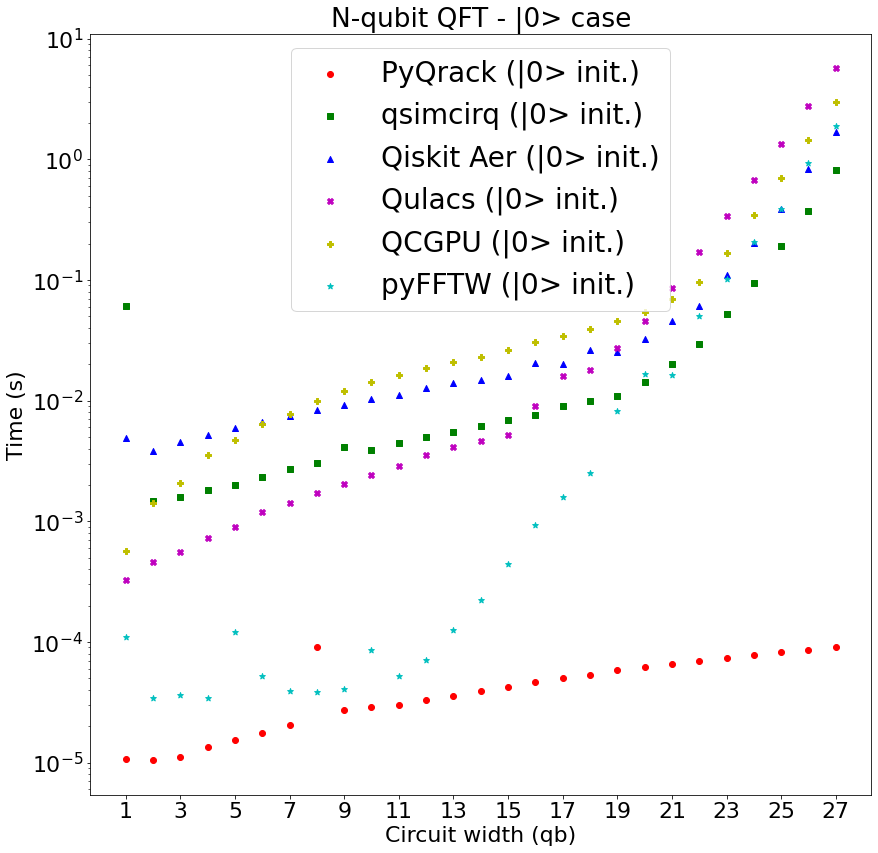

In [13]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("kcymbgr")
markers = list("D*PX^so")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cuquantum_results.keys()
y = cuquantum_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT - |0> case")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "qsimcirq (|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_0_chart.png', dpi=100)

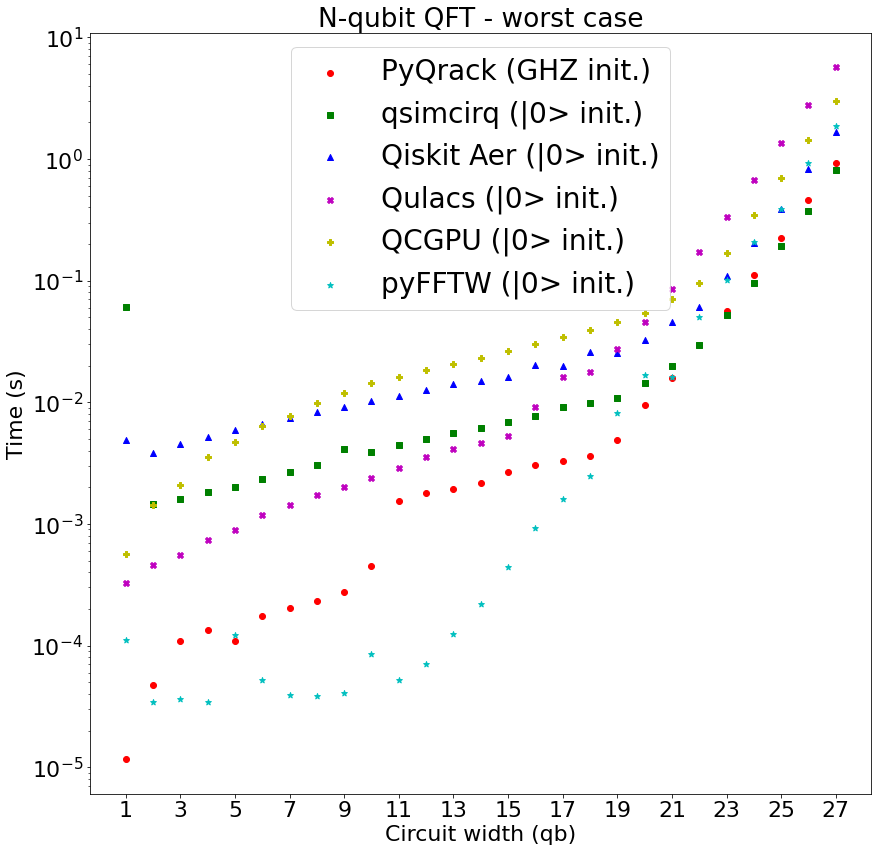

In [14]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)
plt.rc('legend',fontsize=28)
plt.rcParams.update({'font.size': 22})

colors = list("cymbgr")
markers = list("*PX^so")

x = qrack_k_results.keys()
y = qrack_k_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = cuquantum_results.keys()
y = cuquantum_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

x = fftw_0_results.keys()
y = fftw_0_results.values()
plt.scatter(x,y,color=colors.pop(),marker=markers.pop())

plt.title("N-qubit QFT - worst case")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (GHZ init.)",  "qsimcirq (|0> init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=2))

plt.show()

fig.savefig('qft_worst_case_chart.png', dpi=100)

In [15]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2
Linux-5.19.0-35-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-35-generic', version='#36~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Fri Feb 17 15:17:25 UTC 2', machine='x86_64')
Linux
x86_64


In [16]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [17]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'